# Smart Technology - Image Classification

## Extracting CIFAR 10 and CIFAR 100 tar.gz

In [1]:
# For Google Colab to fetch both tar.gz online
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz

!tar -xvzf cifar-10-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1
x cifar-100-python/
x cifar-100-python/file.txt~
x cifar-100-python/train
x cifar-100-python/test
x cifar-100-python/meta


In [2]:
# For local machine to fetch both tar.gz locally
!tar -xvzf cifar-10-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1
x cifar-100-python/
x cifar-100-python/file.txt~
x cifar-100-python/train
x cifar-100-python/test
x cifar-100-python/meta


## Imports

In [3]:
import pickle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split


## Load CIFAR-10 and CIFAR-100

In [4]:
def unpickle(file):
    with open(file, 'rb') as f:
        return pickle.load(f, encoding='bytes')



# CIFAR-10
meta10 = unpickle("cifar-10-batches-py/batches.meta")
cifar10_classes = [x.decode('utf-8') for x in meta10[b'label_names']]

print("CIFAR-10 classes:")
for i, name in enumerate(cifar10_classes):
    print(i, name)




# CIFAR-100
meta100 = unpickle("cifar-100-python/meta")
    
# Extract fine and coarse labels
cifar100_fine_labels = [x.decode('utf-8') for x in meta100[b'fine_label_names']]
cifar100_coarse_labels = [x.decode('utf-8') for x in meta100[b'coarse_label_names']]

print("\nCIFAR-100 Fine Labels (100 classes):")
for i, name in enumerate(cifar100_fine_labels):
    print(i, name)

print("\nCIFAR-100 Coarse Labels (20 superclasses):")
for i, name in enumerate(cifar100_coarse_labels):
    print(i, name)

CIFAR-10 classes:
0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck

CIFAR-100 Fine Labels (100 classes):
0 apple
1 aquarium_fish
2 baby
3 bear
4 beaver
5 bed
6 bee
7 beetle
8 bicycle
9 bottle
10 bowl
11 boy
12 bridge
13 bus
14 butterfly
15 camel
16 can
17 castle
18 caterpillar
19 cattle
20 chair
21 chimpanzee
22 clock
23 cloud
24 cockroach
25 couch
26 crab
27 crocodile
28 cup
29 dinosaur
30 dolphin
31 elephant
32 flatfish
33 forest
34 fox
35 girl
36 hamster
37 house
38 kangaroo
39 keyboard
40 lamp
41 lawn_mower
42 leopard
43 lion
44 lizard
45 lobster
46 man
47 maple_tree
48 motorcycle
49 mountain
50 mouse
51 mushroom
52 oak_tree
53 orange
54 orchid
55 otter
56 palm_tree
57 pear
58 pickup_truck
59 pine_tree
60 plain
61 plate
62 poppy
63 porcupine
64 possum
65 rabbit
66 raccoon
67 ray
68 road
69 rocket
70 rose
71 sea
72 seal
73 shark
74 shrew
75 skunk
76 skyscraper
77 snail
78 snake
79 spider
80 squirrel
81 streetcar
82 sunflower
83 sweet_pepper
84 table
85

## Extracts Selected CIFAR-10 IDs

In [5]:
# Classes we want IDs for
cifar10_target_classes = ["automobile", "bird", "cat", "deer", "dog", "horse", "truck"]

# Extract the indices (IDs)
cifar10_target_classes_ids = [cifar10_classes.index(c) for c in cifar10_target_classes]
print("Selected class IDs:", cifar10_target_classes_ids)





X_train_10 = [] # Images
y_train_10 = [] # Corresponding Labels

# Load all CIFAR-10 training batches
for i in range(1, 6):
    batch = unpickle(f"cifar-10-batches-py/data_batch_{i}")
    X_train_10.append(batch[b'data'])   # X_train_10 contains 5 arrays, each shape (10000, 3072)
    y_train_10.append(batch[b'labels']) # y_train_10 contains 5 arrays, each shape (10000,)

# Merge the 5 arrays into 1
X_train_10 = np.concatenate(X_train_10) # X_train_10 becomes shape (50000, 3072)
y_train_10 = np.concatenate(y_train_10) # y_train_10 becomes shape (50000,)

# Filter selected classes
train_mask_10 = np.isin(y_train_10, cifar10_target_classes_ids)
X_train_10_filtered = X_train_10[train_mask_10]
y_train_10_filtered = y_train_10[train_mask_10]



# Test set
test_batch = unpickle("cifar-10-batches-py/test_batch")
X_test_10 = test_batch[b'data']
y_test_10 = np.array(test_batch[b'labels'])

test_mask_10 = np.isin(y_test_10, cifar10_target_classes_ids)
X_test_10_filtered = X_test_10[test_mask_10]
y_test_10_filtered = y_test_10[test_mask_10]

print("Filtered CIFAR-10 shapes:")
print("\nTrain")
print("Images:", X_train_10_filtered.shape, "\tLabels:", y_train_10_filtered.shape)
print("\nTest")
print("Images:", X_test_10_filtered.shape, "\tLabels:", y_test_10_filtered.shape)


Selected class IDs: [1, 2, 3, 4, 5, 7, 9]
Filtered CIFAR-10 shapes:

Train
Images: (35000, 3072) 	Labels: (35000,)

Test
Images: (7000, 3072) 	Labels: (7000,)


The filtered CIFAR-10 shapes are correct.  

X_train_10_filtered contains 50,000 training images, corresponding to the 10 classes equally.  
Having selected 7 classes, that amount of training images changes to 50,000 * 0.7 = 35,000.  
Each images also possesses 32px x 32px x 3(RGB), hence the 3072.  
The same could be said to the amount of y_train_10 labels.  
  
x_test_10_filtered contains 10,000 labels, corresponding to the 10 classes equally.  
Having selected 7 classes, that amount of labels changes to 10,000 * 0.7 = 7,000.  

## Extracts Selected CIFAR-100 IDs

To avoid confusion:  
y_train_100_filtered_fine refers to the original CIFAR-100 fine class IDs (0 - 99)  
y_train_100_filtered refers to the new custom class IDs after remap (0 - 16)

In [6]:
# Classes we want IDs for (16)
cifar100_target_fine_classes = ['cattle', 'fox', 'baby', 'boy', 'girl', 'man', 'woman', 'rabbit', 'squirrel', 'bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train', 'lawn_mower', 'tractor']

# Extract the indices (IDs)
cifar100_target_fine_classes_ids = [cifar100_fine_labels.index(name) for name in cifar100_target_fine_classes]
cifar100_trees_coarse_id = cifar100_coarse_labels.index("trees")



# meta file does not contain direct mapping from fine labels to coarse labels.
# therefore "cifar-100-python/train"
train100 = unpickle("cifar-100-python/train")
fine_to_coarse = train100[b'coarse_labels']

# A unique fine to coarse mapping to avoid repeating compute
fine_to_coarse_unique = {}
for fine_id, coarse_id in zip(train100[b'fine_labels'], train100[b'coarse_labels']):
    fine_to_coarse_unique[fine_id] = coarse_id

# Extract all fine-label IDs belonging to the "trees" superclass
trees_fine_ids = [fine_id for fine_id, coarse_id in fine_to_coarse_unique.items()
                  if coarse_id == cifar100_trees_coarse_id]

# 16 selected fine classes -> IDs 0–15
# trees (merged) -> ID 16
merged_class_id = 16

# key: fine_label_id,    value: new class ID
cifar100_id_mapping = {}

# Add selected fine classes
for new_id, fine_id in enumerate(cifar100_target_fine_classes_ids):
    cifar100_id_mapping[fine_id] = new_id

# Add merged trees class
for fine_id in trees_fine_ids:
    cifar100_id_mapping[fine_id] = merged_class_id





# Filter selected classes
X_train_100 = train100[b'data']
y_train_100_fine = np.array(train100[b'fine_labels'])

# Keep samples where fine_id is in either "cifar100_target_fine_classes_ids" or 'trees_fine_ids"
train_mask_100 = np.isin(y_train_100_fine, 
                         cifar100_target_fine_classes_ids + trees_fine_ids)

X_train_100_filtered = X_train_100[train_mask_100]
y_train_100_filtered_fine = y_train_100_fine[train_mask_100]

# Remap labels using cifar100_id_mapping
y_train_100_filtered = np.array([cifar100_id_mapping[f] 
                                 for f in y_train_100_filtered_fine])



# Same for Test Set
test100 = unpickle("cifar-100-python/test")
X_test_100 = test100[b'data']
y_test_100_fine = np.array(test100[b'fine_labels'])

test_mask_100 = np.isin(y_test_100_fine,
                        cifar100_target_fine_classes_ids + trees_fine_ids)

X_test_100_filtered = X_test_100[test_mask_100]
y_test_100_filtered_fine = y_test_100_fine[test_mask_100]

y_test_100_filtered = np.array([cifar100_id_mapping[f] 
                                for f in y_test_100_filtered_fine])





print("Selected CIFAR-100 Fine Class IDs:")
print(cifar100_target_fine_classes_ids)

print("\nFine IDs under 'trees' coarse class:")
print(trees_fine_ids)

print("\nAssigned merged class ID:", merged_class_id)

print("\nCIFAR-100 class mapping (fine_id -> new_class_id):")
for fine_id, new_id in cifar100_id_mapping.items():
    print(f"Fine ID {fine_id:<3} -> New Class ID {new_id}")


print("\nTrain")
print("Images:", X_train_100_filtered.shape, "\tLabels:", y_train_100_filtered.shape)

print("\nTest")
print("Images:", X_test_100_filtered.shape,  "\tLabels:", y_test_100_filtered.shape)

Selected CIFAR-100 Fine Class IDs:
[19, 34, 2, 11, 35, 46, 98, 65, 80, 8, 13, 48, 58, 90, 41, 89]

Fine IDs under 'trees' coarse class:
[96, 59, 52, 47, 56]

Assigned merged class ID: 16

CIFAR-100 class mapping (fine_id -> new_class_id):
Fine ID 19  -> New Class ID 0
Fine ID 34  -> New Class ID 1
Fine ID 2   -> New Class ID 2
Fine ID 11  -> New Class ID 3
Fine ID 35  -> New Class ID 4
Fine ID 46  -> New Class ID 5
Fine ID 98  -> New Class ID 6
Fine ID 65  -> New Class ID 7
Fine ID 80  -> New Class ID 8
Fine ID 8   -> New Class ID 9
Fine ID 13  -> New Class ID 10
Fine ID 48  -> New Class ID 11
Fine ID 58  -> New Class ID 12
Fine ID 90  -> New Class ID 13
Fine ID 41  -> New Class ID 14
Fine ID 89  -> New Class ID 15
Fine ID 96  -> New Class ID 16
Fine ID 59  -> New Class ID 16
Fine ID 52  -> New Class ID 16
Fine ID 47  -> New Class ID 16
Fine ID 56  -> New Class ID 16

Train
Images: (10500, 3072) 	Labels: (10500,)

Test
Images: (2100, 3072) 	Labels: (2100,)


The filtered CIFAR-100 shapes are correct.  

X_train_100_filtered contains 50,000 training images, corresponding to the 100 classes equally.  
Having selected 16 + 5 classes, that amount of training images changes to 50,000/100 * 21 = 10,500.  
Each images also possesses 32px x 32px x 3(RGB), hence the 3072.  
The same could be said to the amount of y_train_10 labels.  
  
x_test_100_filtered contains 10,000 labels, corresponding to the 100 classes equally.  
Having selected 7 classes, that amount of labels changes to 10,000/100 * 21 = 2,100.

### Remapping Label as ID to avoid collision

In [7]:
# Build unified label mapping for both datasets

# CIFAR-10 final label space: 0–6
cifar10_remap = {
    old_id: new_id
    for new_id, old_id in enumerate(cifar10_target_classes_ids)
}

# CIFAR-100 final label space: 7–23
cifar100_remap = {
    fine_id: (new_id + len(cifar10_target_classes_ids))   # shift by 7
    for fine_id, new_id in cifar100_id_mapping.items()
}

print("CIFAR-10 remap:")
for old_id, new_id in cifar10_remap.items():
    print(f"  {old_id:<3} -> {new_id}")

print("\nCIFAR-100 remap:")
for old_id, new_id in cifar100_remap.items():
    print(f"  {old_id:<3} -> {new_id}")


print("\nUnique fine labels in filtered CIFAR-100:", np.unique(y_train_100_filtered_fine))


# Remapping

# CIFAR-10 (7 classes)
y_train_10_final = np.array([cifar10_remap[y] for y in y_train_10_filtered])
y_test_10_final  = np.array([cifar10_remap[y] for y in y_test_10_filtered])

# CIFAR-100 (17 classes)
y_train_100_final = np.array([cifar100_remap[y] for y in y_train_100_filtered_fine])
y_test_100_final  = np.array([cifar100_remap[y] for y in y_test_100_filtered_fine])



# Combine Filtered CIFAR-10 datasets and filtered CIFAR-100 datasets
X_train_combined = np.concatenate([X_train_10_filtered, X_train_100_filtered], axis=0)
y_train_combined = np.concatenate([y_train_10_final,  y_train_100_final],  axis=0)

X_test_combined  = np.concatenate([X_test_10_filtered,  X_test_100_filtered],  axis=0)
y_test_combined  = np.concatenate([y_test_10_final,   y_test_100_final],   axis=0)

print("\nCombined train shape:", X_train_combined.shape, y_train_combined.shape)
print("Combined test shape:",  X_test_combined.shape,  y_test_combined.shape)

print("\nUnique training labels:", np.unique(y_train_combined))
print("Unique test labels: ", np.unique(y_test_combined))



CIFAR-10 remap:
  1   -> 0
  2   -> 1
  3   -> 2
  4   -> 3
  5   -> 4
  7   -> 5
  9   -> 6

CIFAR-100 remap:
  19  -> 7
  34  -> 8
  2   -> 9
  11  -> 10
  35  -> 11
  46  -> 12
  98  -> 13
  65  -> 14
  80  -> 15
  8   -> 16
  13  -> 17
  48  -> 18
  58  -> 19
  90  -> 20
  41  -> 21
  89  -> 22
  96  -> 23
  59  -> 23
  52  -> 23
  47  -> 23
  56  -> 23

Unique fine labels in filtered CIFAR-100: [ 2  8 11 13 19 34 35 41 46 47 48 52 56 58 59 65 80 89 90 96 98]

Combined train shape: (45500, 3072) (45500,)
Combined test shape: (9100, 3072) (9100,)

Unique training labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Unique test labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


## Verify Correct Remapping

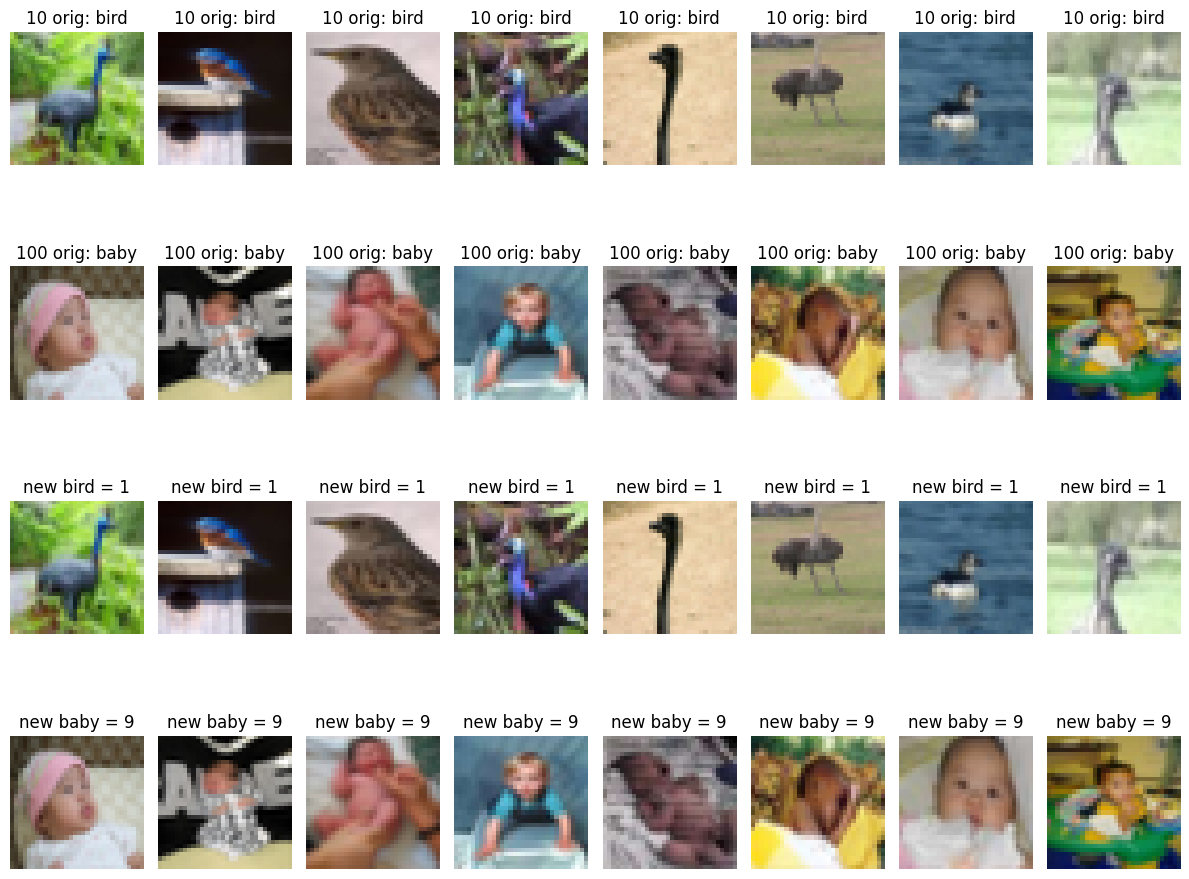

CIFAR-10 'bird' 	old label 2 -> new label = 1
CIFAR-100 'baby' 	old label 2 -> new label = 9


In [8]:
# Classes to to verify as they have same ID 2
orig_class_10 = "bird"
orig_class_100 = "baby"

# original label IDs
orig_label_10 = cifar10_classes.index(orig_class_10)
orig_label_100 = cifar100_fine_labels.index(orig_class_100)

# original samples
indices_10_orig  = np.where(y_train_10 == orig_label_10)[0][:8]
indices_100_orig = np.where(y_train_100_fine == orig_label_100)[0][:8]

new_label_10  = cifar10_remap[orig_label_10]
new_label_100 = cifar100_remap[orig_label_100]

# new samples after filter + remap
indices_10_new  = np.where(y_train_10_final == new_label_10)[0][:8]
indices_100_new = np.where(y_train_100_final == new_label_100)[0][:8]



def decode_cifar(flat):
    return flat.reshape(3,32,32).transpose(1,2,0)




plt.figure(figsize=(12, 10))

# Row 1: CIFAR-10 ORIGINAL
for i, idx in enumerate(indices_10_orig):
    img = decode_cifar(X_train_10[idx])
    plt.subplot(4, 8, i+1)
    plt.imshow(img)
    plt.title("10 orig: bird")
    plt.axis("off")

# Row 2: CIFAR-100 ORIGINAL
for i, idx in enumerate(indices_100_orig):
    img = decode_cifar(X_train_100[idx])
    plt.subplot(4, 8, i+1+8)
    plt.imshow(img)
    plt.title("100 orig: baby")
    plt.axis("off")

# Row 3: CIFAR-10 NEW LABEL
for i, idx in enumerate(indices_10_new):
    img = decode_cifar(X_train_10_filtered[idx])
    plt.subplot(4, 8, i+1+16)
    plt.imshow(img)
    plt.title(f"new bird = {new_label_10}")
    plt.axis("off")

# Row 4: CIFAR-100 NEW LABEL
for i, idx in enumerate(indices_100_new):
    img = decode_cifar(X_train_100_filtered[idx])
    plt.subplot(4, 8, i+1+24)
    plt.imshow(img)
    plt.title(f"new baby = {new_label_100}")
    plt.axis("off")

plt.tight_layout()
plt.show()

print(f"CIFAR-10 '{orig_class_10}' \told label {orig_label_10} -> new label = {new_label_10}")
print(f"CIFAR-100 '{orig_class_100}' \told label {orig_label_100} -> new label = {new_label_100}")


### Combine CIFAR-10 and CIFAR-100 and save files

In [9]:
# Combine CIFAR-10 and CIFAR-100
X_train_combined = np.concatenate([X_train_10_filtered, X_train_100_filtered], axis=0)
y_train_combined = np.concatenate([y_train_10_final,  y_train_100_final],  axis=0)

X_test_combined  = np.concatenate([X_test_10_filtered,  X_test_100_filtered],  axis=0)
y_test_combined  = np.concatenate([y_test_10_final,   y_test_100_final],   axis=0)

print("\nCombined train shape:\t", X_train_combined.shape, y_train_combined.shape)
print("Combined test shape:\t",  X_test_combined.shape,  y_test_combined.shape)



# Validation split
# val_split = int(0.1 * X_train_combined.shape[0])

# val_data = {
#     'features': X_train_combined[:val_split],
#     'labels':   y_train_combined[:val_split]
# }

# train_data = {
#     'features': X_train_combined[val_split:],
#     'labels':   y_train_combined[val_split:]
# }

# test_data = {
#     'features': X_test_combined,
#     'labels':   y_test_combined
# }

# Stratified
X_train, X_val, y_train, y_val = train_test_split(
    X_train_combined, y_train_combined,
    test_size=0.10,
    stratify=y_train_combined,
    random_state=42
)

train_data = {'features': X_train, 'labels': y_train}
val_data   = {'features': X_val,   'labels': y_val}
test_data  = {'features': X_test_combined, 'labels': y_test_combined}

print("\nFinal dataset shapes:")
print("Train:\t\t\t", train_data['features'].shape, train_data['labels'].shape)
print("Validation:\t\t", val_data['features'].shape, val_data['labels'].shape)
print("Test:\t\t\t", test_data['features'].shape, test_data['labels'].shape)

print("\nUnique training labels:\t", np.unique(y_train_combined))
print("Unique test labels:\t", np.unique(y_test_combined))



# Save files
os.makedirs('combined', exist_ok=True)

with open('combined/train.p', 'wb') as f:
    pickle.dump(train_data, f)

with open('combined/valid.p', 'wb') as f:
    pickle.dump(val_data, f)

with open('combined/test.p', 'wb') as f:
    pickle.dump(test_data, f)

print("\nSaved:\t\tcombined/train.p\t\tcombined/valid.p\t\tcombined/test.p")



Combined train shape:	 (45500, 3072) (45500,)
Combined test shape:	 (9100, 3072) (9100,)

Final dataset shapes:
Train:			 (40950, 3072) (40950,)
Validation:		 (4550, 3072) (4550,)
Test:			 (9100, 3072) (9100,)

Unique training labels:	 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Unique test labels:	 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Saved:		combined/train.p		combined/valid.p		combined/test.p


Now we are reading in the train_data, val_data and test_data that we just created and checking the shape

## Load in Freshly Created Combined Files

In [10]:
# Load the saved combined dataset
with open('combined/train.p', 'rb') as f:
    train_data = pickle.load(f)

with open('combined/valid.p', 'rb') as f:
    val_data = pickle.load(f)

with open('combined/test.p', 'rb') as f:
    test_data = pickle.load(f)

X_train = train_data['features']
y_train = train_data['labels']

X_val = val_data['features']
y_val = val_data['labels']

X_test = test_data['features']
y_test = test_data['labels']


print("Feature shapes:")
print("\tTrain:\t\t", X_train.shape)
print("\tValidation:\t", X_val.shape)
print("\tTest:\t\t", X_test.shape)

print("\nLabel shapes:")
print("\tTrain:\t\t", y_train.shape)
print("\tValidation:\t", y_val.shape)
print("\tTest:\t\t", y_test.shape)

print("\nUnique train labels:", np.unique(y_train))
print("Unique test labels: ", np.unique(y_test))

Feature shapes:
	Train:		 (40950, 3072)
	Validation:	 (4550, 3072)
	Test:		 (9100, 3072)

Label shapes:
	Train:		 (40950,)
	Validation:	 (4550,)
	Test:		 (9100,)

Unique train labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Unique test labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


## Reshape Flattened Images Back into RGB Images

Reshape is required as the images loaded back in are flattend.  
Flattened images are not able to be pre-processed due to incorrect sizes.  
Therefore, we reshape them into (32 x 32 x 3), matching Machine Learning Frameworks.  
In contrast to CIFAR's (3 x 32 x 32).

In [11]:
# Reshape combined CIFAR images after loading it in
def reshape_cifar(X):
    return X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

X_train = reshape_cifar(X_train)
X_val = reshape_cifar(X_val)
X_test = reshape_cifar(X_test)

print("Reshaped datasets:")
print("Train:\t\t", X_train.shape)
print("Val:\t\t", X_val.shape)
print("Test:\t\t", X_test.shape)


Reshaped datasets:
Train:		 (40950, 32, 32, 3)
Val:		 (4550, 32, 32, 3)
Test:		 (9100, 32, 32, 3)


## Data Pre-Processing

In [12]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, ksize=(3, 3)):
    return cv2.GaussianBlur(img, ksize, 0)

def equalize(img):
    return cv2.equalizeHist(img)

def normalize(img):
    return img / 255.0

def preprocessing(img):
    # img = grayscale(img)
    img = gaussian_blur(img, (3, 3))
    # img = equalize(img)
    img = normalize(img)
    return img

1. Grayscale helps:  
    a. Reduce computation, uses 1 instead of 3 channels  
    b. Remove color biases  
    c. Forces the model to focus on the shape and edges  
  
2. Histogram Equalization helps:  
    a. Improve contrast by spreading out pixel intensities  
    b. Dark images becomes brighter  
    c. Bright images becomes more consistent  
    d. Makes shapes and edges more visible  
  
3. Normalization:
    a. Prevents vanishing gradients

### Displaying each

X_train shape: (40950, 32, 32, 3)


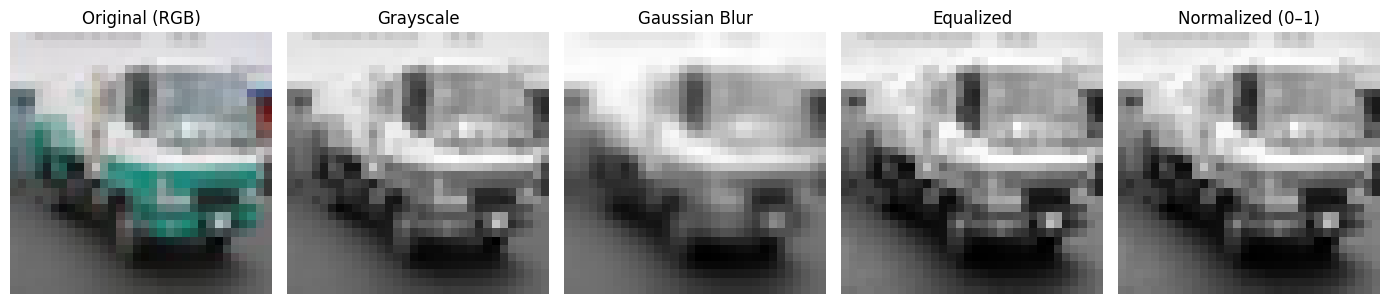

Original shape: (32, 32, 3)
Grayscale shape: (32, 32)
Blurred shape: (32, 32)
Equalized shape: (32, 32)
Normalized min/max: 0.0 1.0


In [13]:
print("X_train shape:", X_train.shape)
assert X_train.shape[1:] == (32, 32, 3)

random_index = 555
img_original = X_train[random_index] # shape (32,32,3)

img_gray = grayscale(img_original)
img_blurred = gaussian_blur(img_gray)
img_equalized = equalize(img_gray)
img_normalized = normalize(img_equalized)

plt.figure(figsize=(14, 4))

# Original RGB
plt.subplot(1, 5, 1)
plt.imshow(img_original)
plt.title("Original (RGB)")
plt.axis("off")

# Grayscale
plt.subplot(1, 5, 2)
plt.imshow(img_gray, cmap='gray')
plt.title("Grayscale")
plt.axis("off")

# Blurred
plt.subplot(1, 5, 3)
plt.imshow(img_blurred, cmap='gray')
plt.title("Gaussian Blur")
plt.axis("off")

# Equalized
plt.subplot(1, 5, 4)
plt.imshow(img_equalized, cmap='gray')
plt.title("Equalized")
plt.axis("off")

# Normalized
plt.subplot(1, 5, 5)
plt.imshow(img_normalized, cmap='gray')
plt.title("Normalized (0–1)")
plt.axis("off")
plt.tight_layout()
plt.show()

print("Original shape:", img_original.shape)
print("Grayscale shape:", img_gray.shape)
print("Blurred shape:", img_blurred.shape)
print("Equalized shape:", img_equalized.shape)
print("Normalized min/max:", img_normalized.min(), img_normalized.max())


### Reshaping

In [14]:
# Apply preprocessing to entire dataset
print("Before preprocessing:")
print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

# Apply preprocessing to each image
X_train = np.array(list(map(preprocessing, X_train)))
X_val   = np.array(list(map(preprocessing, X_val)))
X_test  = np.array(list(map(preprocessing, X_test)))

# Add channel dimension: (N,32,32) -> (N,32,32,1)
# X_train = X_train.reshape(-1, 32, 32, 1)
# X_val   = X_val.reshape(-1, 32, 32, 1)
# X_test  = X_test.reshape(-1, 32, 32, 1)
X_train = X_train.reshape(-1, 32, 32, 3)
X_val   = X_val.reshape(-1, 32, 32, 3)
X_test  = X_test.reshape(-1, 32, 32, 3)

print("\nAfter preprocessing:")
print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


Before preprocessing:
Train: (40950, 32, 32, 3)
Val:   (4550, 32, 32, 3)
Test:  (9100, 32, 32, 3)

After preprocessing:
Train: (40950, 32, 32, 3)
Val:   (4550, 32, 32, 3)
Test:  (9100, 32, 32, 3)


# Data Exploration

In [15]:
# Display dataset shape, images, labels, classes, and label counts
print(f"Training shape:\t\t{X_train.shape}")
print(f"Training images:\t{X_train.shape[0]}")
print(f"Training labels:\t{y_train.shape[0]}")
print(f"Training classes:\t{len(np.unique(y_train))}")
print(f"Training label counts:")
print(np.array2string(np.bincount(y_train), max_line_width=10_000))

print(f"\nValidation shape:\t{X_val.shape}")
print(f"Validation images:\t{X_val.shape[0]}")
print(f"Validation labels:\t{y_val.shape[0]}")
print(f"Validation classes:\t{len(np.unique(y_val))}")
print(f"Val label counts:")
print(np.array2string(np.bincount(y_val), max_line_width=10_000))

print(f"\nTesting shape:\t\t{X_test.shape}")
print(f"Testing images:\t\t{X_test.shape[0]}")
print(f"Testing labels:\t\t{y_test.shape[0]}")
print(f"Testing classes:\t{len(np.unique(y_test))}")
print(f"Test label counts:")
print(np.array2string(np.bincount(y_test), max_line_width=10_000))

print("\nUnique CIFAR-10 labels:\t\t", np.unique(y_train_10_filtered))
print("Unique CIFAR-100 labels:\t", np.unique(y_train_100_filtered))
print("Combined unique labels:\t\t", np.unique(y_train_combined))

Training shape:		(40950, 32, 32, 3)
Training images:	40950
Training labels:	40950
Training classes:	24
Training label counts:
[4500 4500 4500 4500 4500 4500 4500  450  450  450  450  450  450  450  450  450  450  450  450  450  450  450  450 2250]

Validation shape:	(4550, 32, 32, 3)
Validation images:	4550
Validation labels:	4550
Validation classes:	24
Val label counts:
[500 500 500 500 500 500 500  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50 250]

Testing shape:		(9100, 32, 32, 3)
Testing images:		9100
Testing labels:		9100
Testing classes:	24
Test label counts:
[1000 1000 1000 1000 1000 1000 1000  100  100  100  100  100  100  100  100  100  100  100  100  100  100  100  100  500]

Unique CIFAR-10 labels:		 [1 2 3 4 5 7 9]
Unique CIFAR-100 labels:	 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Combined unique labels:		 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


## Classes Visualisation

Number of classes: 24


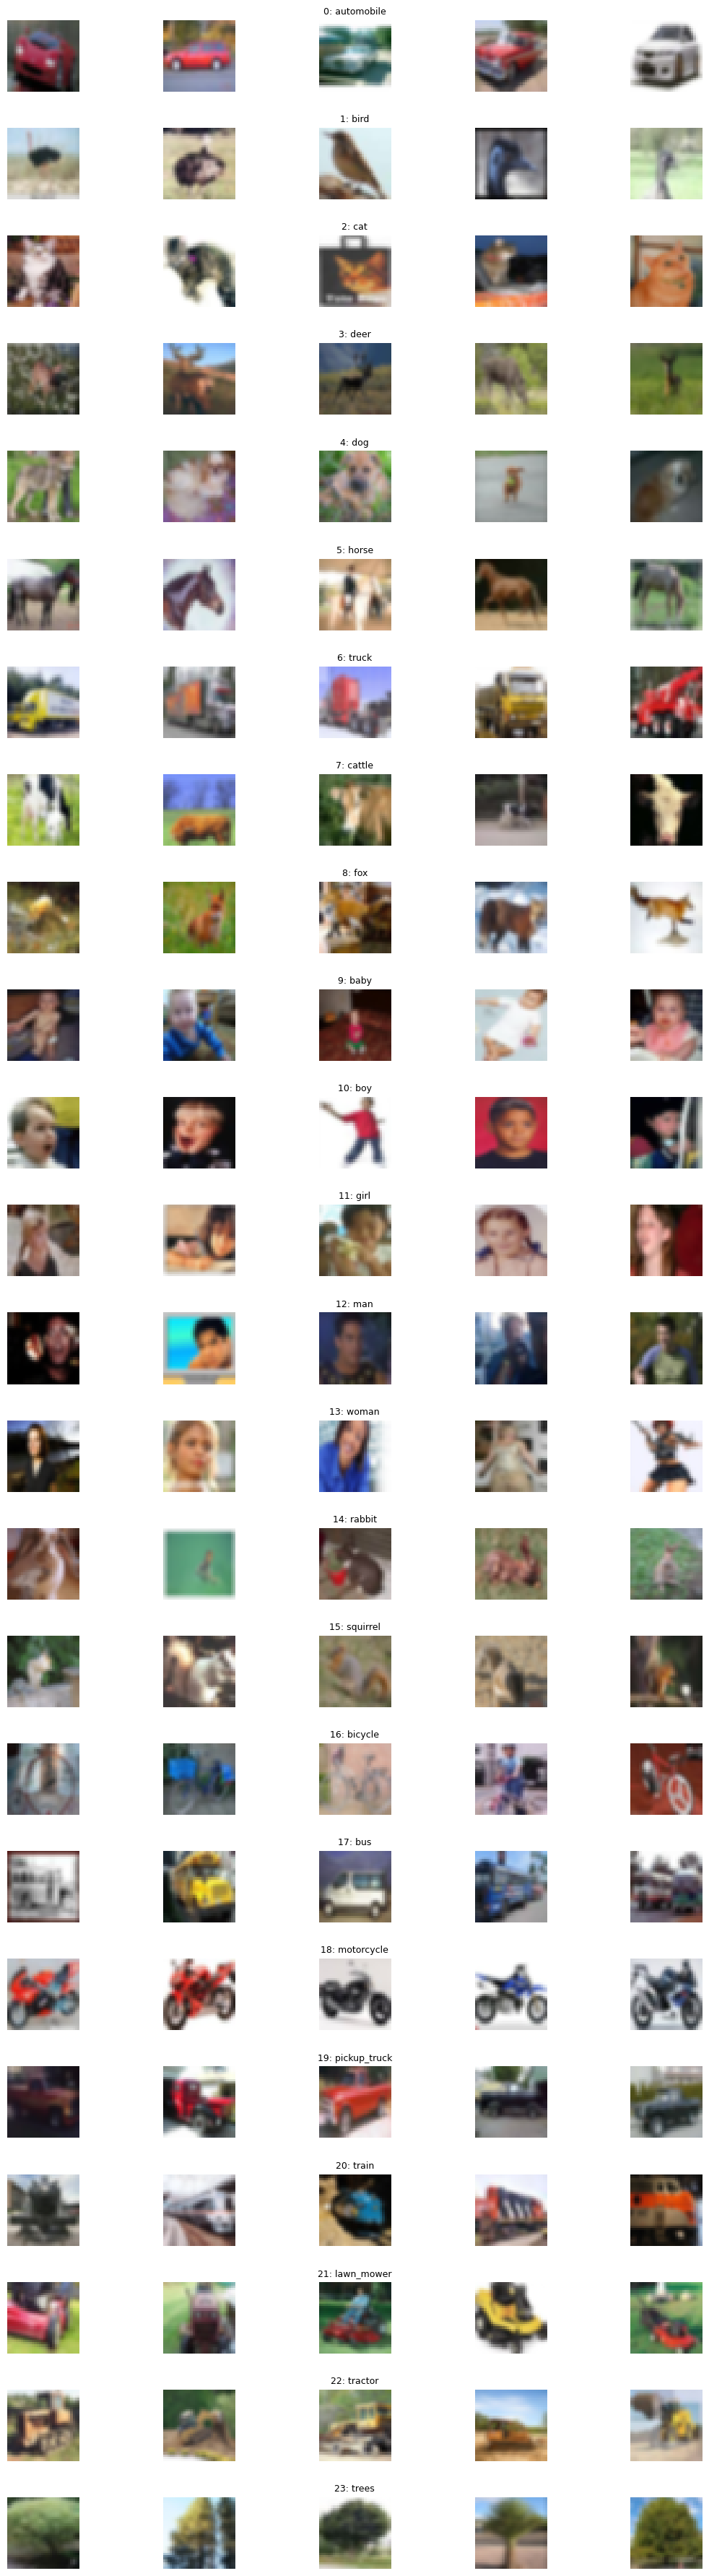

In [16]:
# Build lookup table for class_id -> class_name

# CIFAR-10 names (labels 0–6)
cifar10_names_remapped = {
    new_id: cifar10_target_classes[new_id]
    for new_id in range(len(cifar10_target_classes))
}

# CIFAR-100 names (labels 7–23)
cifar100_names_remapped = {
    (new_id + len(cifar10_target_classes)): name
    for new_id, name in enumerate(cifar100_target_fine_classes + ["trees"])
}

# Merge into one dict
combined_class_names = {**cifar10_names_remapped, **cifar100_names_remapped}



# Visualization parameters
cols = 5
classes = np.unique(y_train)
num_classes = len(classes)

print("Number of classes:", num_classes)



fig, axs = plt.subplots(
    nrows=num_classes,
    ncols=cols,
    figsize=(cols * 2.2, num_classes * 1.5)
)
fig.tight_layout(pad=1.5)



# Plot random samples for each class
for row_idx, class_id in enumerate(classes):
    
    # Get all images that belong to this class
    class_images = X_train[y_train == class_id]

    for col in range(cols):
        ax = axs[row_idx][col]

        # Pick random image from this class
        rand_index = random.randint(0, len(class_images) - 1)

        # If grayscale shape (32,32,1), squeeze to (32,32)
        # img = class_images[rand_index].squeeze()
        img = class_images[rand_index]

        ax.imshow(img, cmap='gray')
        ax.axis("off")

        # Put class name in the center column
        if col == cols // 2:
            ax.set_title(f"{class_id}: {combined_class_names[class_id]}", fontsize=9)

plt.show()


## Distribution Bar Chart

In [17]:
# # Compute number of samples per class
# num_of_samples = []
# classes = np.unique(y_train)

# for class_id in classes:
#     num_of_samples.append(np.sum(y_train == class_id))

# print("Class distribution (Training Set):")
# for class_id, count in zip(classes, num_of_samples):
#     print(f"  Class {class_id:2d} -> {count}")



# # Bar chart for Training set
# plt.figure(figsize=(14, 5))
# plt.bar(classes, num_of_samples)

# plt.title("Distribution of Training Set", fontsize=16)
# plt.xlabel("Class ID", fontsize=12)
# plt.ylabel("Number of Images", fontsize=12)

# plt.xticks(classes)  # ensure all class IDs appear on the x-axis

# plt.show()





# # num_val_samples = []
# # val_classes = np.unique(y_val)

# # for class_id in val_classes:
# #     num_val_samples.append(np.sum(y_val == class_id))

# # print("\nClass distribution (Validation Set):")
# # for class_id, count in zip(val_classes, num_val_samples):
# #     print(f"  Class {class_id:2d} -> {count}")


# # # Bar chart for Validation set
# # plt.figure(figsize=(14, 5))
# # plt.bar(val_classes, num_val_samples, color='orange')

# # plt.title("Distribution of Validation Set", fontsize=16)
# # plt.xlabel("Class ID", fontsize=12)
# # plt.ylabel("Number of Images", fontsize=12)
# # plt.xticks(val_classes)

# # plt.show()


This Class Distribution Bar Chart for both Training and Validation set is correct. 
   
CIFAR-10 classes (0 - 6) dominates because each CIFAR-10 classes has 10 times more images than each CIFAR-100 classes.  
The final CIFAR-100 trees class (23) appears like so in the chart as it combines 5 fine labels into one.  

## What size are the images and what classes do the images represent?

All images within the combined datasets originally had a shape of (32, 32, 3), which represents the 32 pixels x 32 pixels x 3 colour channels (RGB).   
After preprocessing (grayscale -> gaussian blur -> equalisation ->  normalisation) the images are shaped into (32, 32, 1) as they are now single-chanel grayscale.  
  
The 24 classes are represented by the 7 classes selected from CIFAR-10, and 17 classes selected from CIFAR-100. Thus, the 24 classes of images.

## Comment on relative numbers of each type of image

As the behaviour of both Training and Validation set are the same, in this block, I will primarily be talking about the Training set. Do know that whatever mentioned here, can be applied to the Validation set as well.  

Having observed the distribution of Training Set of the combined dataset of CIFAR-10 and CIFAR-100 above, we can clearly see a huge difference, or what we would like to call, a class imbalance, in the number of images between CIFAR-10 and CIFAR-100.  
  
The output of the number of samples is this:  
[4397, 4326, 4360, 4323, 4363, 4351, 4330, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]  

The Distribution Bar Chart shows:  
 - Classes from 0 to 6 (CIFAR-10) consists around 4,300 to 4,400 images per class
 - Classes from 7 to 23 (CIFAR-100) consists around 500 images per class
 - Class 23 (Merged CIFAR-100 trees class) contains around 2,500 images per class, as it combines 5 fine labels into 1

The first 7 classes are from CIFAR-10, around 4300, and the rest with 500 each are from CIFAR-100. This imbalance can bias the model towards classes with more samples leading to higher accuracy for CIFAR10 classes but lower accuracy for CIFAR100 classes.  

This behavior is not out of the norm due to how CIFAR-10 and CIFAR-100 are structured.  
 - CIFAR-10 has 50,000 training images split evenly across 10 classes, making it 5,000 images per class
 - 7 CIFAR-10 classes selected, meant 7 * 5,000 = 35,000 images in total
 - After train val split, each CIFAR-10 class ends up with approximately: 0.9 * 5,000 = 4,500 images
 - This matches the Distribution Bar Chart shown above
  
  
 - CIFAR-100 has 50,000 training images split evenly across 100 classes, making it 500 images per class
 - 16 CIFAR-100 fine classes and 1 CIFAR-100 coarse class selected, and from that 1 coarse class, 5 fine classes were introduced.
 - Therefore, 16 + 5 CIFAR-100 fine classes selected, meant 21 * 500 = 10,500 images in total
 - After train val split, each CIFAR-100 class ends up with approximately: 0.9 * 500 = 450 images, except for the combined fine class
 - This matches the Distribution Bar Chart shown above
  
  
If this distribution imbalance are not approached properly, it could result in:  
 - Model learning more on CIFAR-10 classes than CIFAR-100 classes
 - Perform extremely poorly on CIFAR-100 classes due to hardly any images sample
 - Biased towards predicting CIFAR-10 classes
This will be a major concern for our classification accuracy down the line.  

To combat this imbalance, we have proposed several methods:
 1. Data Augmentation, increase number of images for CIFAR-100 classes (Rotations, flips, random crops, brightness changes, etc)
 2. Oversampling CIFAR-100 classes, duplicating the images to reach similar image count as CIFAR-10 classes.
 3. Class Weights during training, assigning higher importance to CIFAR-100 classes.

## Data Augmentation Demonstration

In [18]:
# # Data Augmentation Demonstration (A single sample)

# # Pick any random training image
# random_index = random.randint(0, X_train.shape[0] - 1)
# # img_original = X_train[random_index].squeeze()   # shape (32,32)
# img_original = X_train[random_index]


# def random_flip(img):
#     return cv2.flip(img, 1) if random.random() < 0.5 else img

# def random_rotate(img):
#     angle = random.randint(-20, 20)
#     M = cv2.getRotationMatrix2D((16, 16), angle, 1.0)
#     return cv2.warpAffine(img, M, (32, 32))

# def random_brightness(img):
#     factor = random.uniform(0.5, 1.5)
#     img = img.astype(np.float32) * factor
#     return np.clip(img, 0, 1)

# def random_zoom(img):
#     zoom_factor = random.uniform(1.0, 1.3)
#     h, w, c = img.shape
#     new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
    
#     zoomed = cv2.resize(img, (new_w, new_h))
    
#     # Crop back to 32x32
#     start_x = (new_w - 32) // 2
#     start_y = (new_h - 32) // 2
#     return zoomed[start_y:start_y+32, start_x:start_x+32]



# # Generate augmented samples
# aug1 = random_flip(img_original)
# aug2 = random_rotate(img_original)
# aug3 = random_brightness(img_original)
# aug4 = random_zoom(img_original)



# # Plot the augmentations
# plt.figure(figsize=(10, 6))

# titles = [
#     "Original",
#     "Random Flip",
#     "Random Rotate",
#     "Random Brightness",
#     "Random Zoom"
# ]

# images = [img_original, aug1, aug2, aug3, aug4]

# for i in range(5):
#     plt.subplot(1, 5, i+1)
#     plt.imshow(images[i], cmap='gray')
#     plt.title(titles[i], fontsize=9)
#     plt.axis("off")

# plt.tight_layout()
# plt.show()


## Data Augmentation

In [19]:
# # Data augmentation for class balancing

# # Augmentation functions
# def aug_flip(img):
#     return cv2.flip(img, 1)

# def aug_rotate(img):
#     angle = random.randint(-20, 20)
#     M = cv2.getRotationMatrix2D((16, 16), angle, 1.0)
#     return cv2.warpAffine(img, M, (32, 32))

# def aug_brightness(img):
#     factor = random.uniform(0.5, 1.5)
#     out = img.astype(np.float32) * factor
#     # return np.clip(out, 0, 1)
#     return np.clip(out, 0, 255).astype(np.uint8)

# def aug_noise(img):
#     noise = np.random.normal(0, 0.05, img.shape)
#     # return np.clip(img + noise, 0, 1)
#     out = img.astype(np.float32) + noise
#     return np.clip(out, 0, 255).astype(np.uint8)

# # Randomly apply one augmentation
# def random_augment(img):
#     funcs = [aug_flip, aug_rotate, aug_brightness, aug_noise]
#     func = random.choice(funcs)
#     return func(img)





# # Balance CIFAR-10 (0-6) and CIFAR-100 (7-23) classes
# print("Original class distribution:")
# print(np.array2string(np.bincount(y_train), max_line_width=10_000))

# classes = np.unique(y_train)

# # Target count = max class count (CIFAR-10 ≈ 4300)
# target_count = max(np.bincount(y_train))
# print("\nBalancing all classes to:", target_count, "\n")

# augmented_images = []
# augmented_labels = []

# for cls in classes:
#     cls_images = X_train[y_train == cls]
#     cls_labels = y_train[y_train == cls]

#     current_count = len(cls_images)

#     # Keep original images
#     augmented_images.append(cls_images)
#     augmented_labels.append(cls_labels)

#     # If this class is smaller, augment
#     if current_count < target_count:
#         needed = target_count - current_count
#         print(f"Class {cls}: augmenting {needed} images...")

#         # Generate augmented samples
#         generated_imgs = []
#         generated_lbls = []

#         for _ in range(needed):
#             # img = cls_images[random.randint(0, current_count - 1)].squeeze()
#             img = cls_images[random.randint(0, current_count - 1)]
#             aug = random_augment(img)
#             # generated_imgs.append(aug.reshape(32, 32, 1))
#             generated_imgs.append(aug)
#             generated_lbls.append(cls)

#         augmented_images.append(np.array(generated_imgs))
#         augmented_labels.append(np.array(generated_lbls))

# # Final balanced training set
# X_train_augmented = np.concatenate(augmented_images, axis=0)
# y_train_augmented = np.concatenate(augmented_labels, axis=0)







# # print("\nOriginal validation distribution:")
# # print(np.array2string(np.bincount(y_val), max_line_width=10_000))

# # val_classes = np.unique(y_val)
# # val_target = max(np.bincount(y_val))   # usually 500 for CIFAR-10 classes

# # print("\nBalancing all validation classes to:", val_target, "\n")


# # aug_val_imgs = []
# # aug_val_lbls = []

# # for cls in val_classes:
# #     cls_imgs = X_val[y_val == cls]
# #     cls_lbls = y_val[y_val == cls]

# #     current_count = len(cls_imgs)

# #     # keep originals
# #     aug_val_imgs.append(cls_imgs)
# #     aug_val_lbls.append(cls_lbls)

# #     # need more? augment
# #     if current_count < val_target:
# #         needed = val_target - current_count
# #         print(f"Val Class {cls}: augmenting {needed} images...")

# #         gen_imgs = []
# #         gen_lbls = []

# #         for _ in range(needed):
# #             img = cls_imgs[random.randint(0, current_count-1)].reshape(32,32,1)
# #             img = img.squeeze()
# #             aug = random_augment(img)
# #             gen_imgs.append(aug.reshape(32,32,1))
# #             gen_lbls.append(cls)

# #         aug_val_imgs.append(np.array(gen_imgs))
# #         aug_val_lbls.append(np.array(gen_lbls))

# # # Final balanced validation set
# # X_val_augmented = np.concatenate(aug_val_imgs, axis=0)
# # y_val_augmented = np.concatenate(aug_val_lbls, axis=0)






# print("\nFinal augmented shape:")
# print("X_train_augmented shape:", X_train_augmented.shape, "\ty_train_augmented shape:", y_train_augmented.shape)
# # print("X_val_augmented shape:", X_val_augmented.shape, "\ty_val_augmented shape:", y_val_augmented.shape)
# print("\nFinal class distribution:")
# print(np.array2string(np.bincount(y_train_augmented), max_line_width=10_000))

# print("\nFinal validation distribution:")
# # print(np.array2string(np.bincount(y_val_augmented), max_line_width=10_000))



# # Save to file
# save_path = "combined"
# os.makedirs(save_path, exist_ok=True)



# # Training
# train_augmented_data = {
#     "features": X_train_augmented,
#     "labels": y_train_augmented
# }

# with open(os.path.join(save_path, "train_augmented.p"), "wb") as f:
#     pickle.dump(train_augmented_data, f)



# # # Validation
# # val_balanced_data = {
# #     "features": X_val_augmented,
# #     "labels": y_val_augmented
# # }
# # with open(os.path.join(save_path, "val_augmented.p"), "wb") as f:
# #     pickle.dump(val_balanced_data, f)



# print("\nSaved augmented dataset to:", os.path.join(save_path, "train_augmented.p"))
# # print("\nSaved augmented dataset to:", os.path.join(save_path, "val_augmented.p"))


## Load "train_augmented.p" and "val_augmented.p"

In [20]:

# # Load augmented training data
# train_augmented_path = "combined/train_augmented.p"

# with open(train_augmented_path, "rb") as f:
#     augmented_data = pickle.load(f)

# # Extract features and labels
# X_train_aug = augmented_data["features"]
# y_train_aug = augmented_data["labels"]

# print("Loaded training augmented dataset:")
# print("Raw X_train_aug shape:", X_train_aug.shape)
# print("Raw y_train_aug shape:", y_train_aug.shape)



# # # Load augmented valdiation data
# # val_augmented_path = "combined/val_augmented.p"

# # with open(val_augmented_path, "rb") as f:
# #     val_data = pickle.load(f)

# # X_val_aug = val_data["features"]
# # y_val_aug = val_data["labels"]

# # print("\nLoaded validation augmented dataset:")
# # print("Raw X_val shape:", X_val_aug.shape)
# # print("Raw y_val shape:", y_val_aug.shape)





# # Final verification
# print("\nFinal X_train_aug shape:", X_train_aug.shape)
# print("Final y_train_aug shape:", y_train_aug.shape)

# # print("\nFinal X_val_aug shape:", X_val_aug.shape)
# # print("Final y_val_aug shape:", y_val_aug.shape)

# print("\nAugmented class distribution:")
# print(np.array2string(np.bincount(y_train_aug), max_line_width=10_000))

# # print("\nAugmented validation distribution:")
# # print(np.array2string(np.bincount(y_val_aug), max_line_width=10_000))


## Revisiting Distribution Bar Chart

In [21]:
# # Distribution bar chart for augmented dataset

# # Compute sample count per class
# classes = np.unique(y_train_aug)
# num_classes = len(classes)
# num_of_samples = [int(np.sum(y_train_aug == cls)) for cls in classes]

# print("\nAugmented Training set")
# print("Number of classes:", num_classes)
# print("Samples per class:", num_of_samples)

# plt.figure(figsize=(12, 5))
# plt.bar(classes, num_of_samples)

# plt.title("Distribution of Augmented Training Set", fontsize=16)
# plt.xlabel("Class ID", fontsize=12)
# plt.ylabel("Number of Images", fontsize=12)

# plt.xticks(classes)  # ensure all class IDs appear on the x-axis
# plt.grid(axis='y', linestyle='--', alpha=0.6)

# plt.show()





# # classes_val = np.unique(y_val_aug)
# # num_classes_val = len(classes_val)
# # num_samples_val = [int(np.sum(y_val_aug == cls)) for cls in classes_val]

# # print("\nAugmented Validation set")
# # print("Number of classes:", num_classes_val)
# # print("Samples per class:", num_samples_val)

# # plt.figure(figsize=(12, 5))
# # plt.bar(classes_val, num_samples_val, color='orange')

# # plt.title("Distribution of Validation Set", fontsize=16)
# # plt.xlabel("Class ID", fontsize=12)
# # plt.ylabel("Number of Images", fontsize=12)

# # plt.xticks(classes_val)
# # plt.grid(axis='y', linestyle='--', alpha=0.6)

# # plt.show()



After performing data augmentation to combat the imbalanced dataset, all of 24 classes now possesses 4,500 images each for Training set, and 500 images each for Validation set.  
This resulted in a uniform class distribution, resolving the previous class image imbalance.  

Now the afore mentioned problems are resolved:  
 - No more -> Model learning more on CIFAR-10 classes than CIFAR-100 classes
 - No more -> Perform extremely poorly on CIFAR-100 classes due to hardly any images sample
 - No more -> Biased towards predicting CIFAR-10 classes


## Convolutional Neural Network (CNN) Model Training

In [22]:
import tensorflow as tf
print(tf.config.list_physical_devices("GPU"))


[]


Training shape: (40950, 32, 32, 3) (40950,)
Validation shape: (4550, 32, 32, 3) (4550,)


c:\Users\YCC52\Desktop\Smart Tech\ML-Image-Classification\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

819/819 ━━━━━━━━━━━━━━━━━━━━ 168s 193ms/step - accuracy: 0.2779 - loss: 3.3068 - val_accuracy: 0.4009 - val_loss: 2.5887


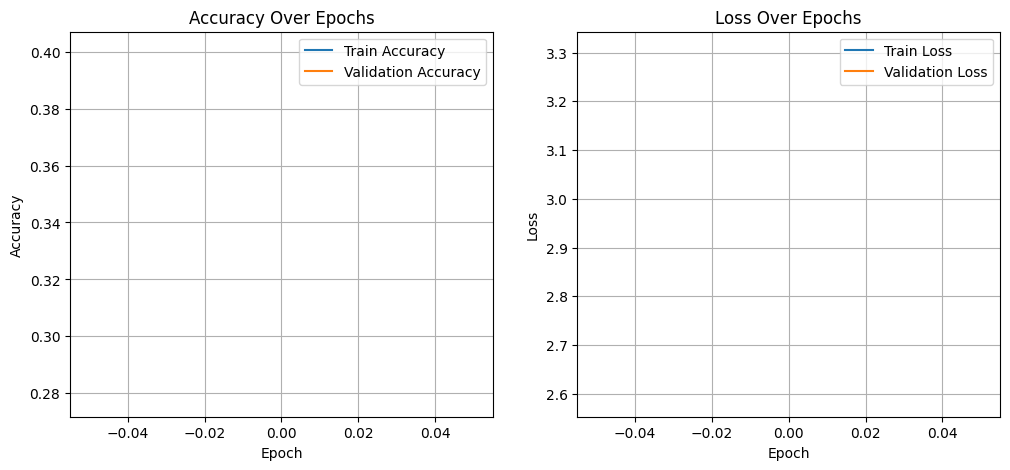

In [ ]:
# Load augmented dataset

# with open("combined/train_augmented.p", "rb") as f:
#     data = pickle.load(f)

# X_train = data["features"]
# y_train = data["labels"]


# X_val = val_data["features"]
# y_val = val_data["labels"]

print("Training shape:", X_train.shape, y_train.shape)
# print("Validation shape:", X_val_aug.shape, y_val_aug.shape)
print("Validation shape:", X_val.shape, y_val.shape)



# One-hot encode labels
num_classes = 24
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)



# Build CNN model
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
], name="data_augmentation")


model = Sequential([
    data_augmentation,

    # Block 1
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.30),

    # Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.40),

    # Dense Layers
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),

    Dense(num_classes, activation='softmax')
])



# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()





# Train model
history = model.fit(
    X_train, y_train_cat,
    batch_size=50,
    epochs=1,
    validation_data=(X_val, y_val_cat),
    shuffle=True
)

# Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()


### Model Training (Underfitting)

In [24]:
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

def leNet_model_underfit():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32,32,1),  activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = leNet_model_underfit()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 500)            │       540,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │        12,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 570,314 (2.18 MB)

 Trainable params: 570,314 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
batch_size = 50
epochs = 15

history = model.fit(
    X_train, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val_cat),
    shuffle=True,
    verbose=1
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

score = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"Test Loss: {score[0]:.4f}")
print(f"Test Accuracy: {score[1]:.4f}")

Epoch 1/15


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_6" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (50, 32, 32, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(50, 32, 32, 3), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

This model underfits because it is too simple relative to the complexity of the dataset.

It uses:
 - Only two convolution layers (60 and 30 filters) 
 - Small filter sizes (5X5) 
 - A relatively small Dense layer (500 units) 
 - Dropout, which further reduces model capacity 
 - Just 570 thousands of total parameters 

Because the model does not have enough representational power, it cannot fully learn the complex patterns in CIFAR-10/100 images. This leads to:

 - Training accuracy remaining low (≈45%)
 - Validation accuracy higher than training accuracy
 - Loss curves that gradually decrease but never converge
 - These are classic signs of an underfit.

### Model Training (Overfitting)

In [ ]:

def leNet_model_overfit():
    model = Sequential()
    model.add(Conv2D(60, (3,3), input_shape=(32,32,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(120, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

model_over = leNet_model_overfit()
model_over.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1000)           │     4,609,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 24)             │        12,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,196,020 (19.82 MB)

 Trainable params: 5,196,020 (19.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 233s 110ms/step - accuracy: 0.2768 - loss: 2.2747 - val_accuracy: 0.5277 - val_loss: 1.4111
Epoch 2/15
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 260s 126ms/step - accuracy: 0.3845 - loss: 1.9197 - val_accuracy: 0.5545 - val_loss: 1.3928
Epoch 3/15
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 250s 120ms/step - accuracy: 0.4501 - loss: 1.7037 - val_accuracy: 0.5822 - val_loss: 1.2696
Epoch 4/15
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 270s 124ms/step - accuracy: 0.5157 - loss: 1.4825 - val_accuracy: 0.5563 - val_loss: 1.3477
Epoch 5/15
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 260s 125ms/step - accuracy: 0.5910 - loss: 1.2433 - val_accuracy: 0.5714 - val_loss: 1.3216
Epoch 6/15
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 265s 128ms/step - accuracy: 0.6689 - loss: 0.9961 - val_accuracy: 0.5637 - val_loss: 1.3779
Epoch 7/15
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 283s 136ms/step - accuracy: 0.7414 - loss: 0.7691 - val_accuracy: 0.5305 - val_loss: 1.5606
Epoch 8/15
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 214s 104ms/step - ac

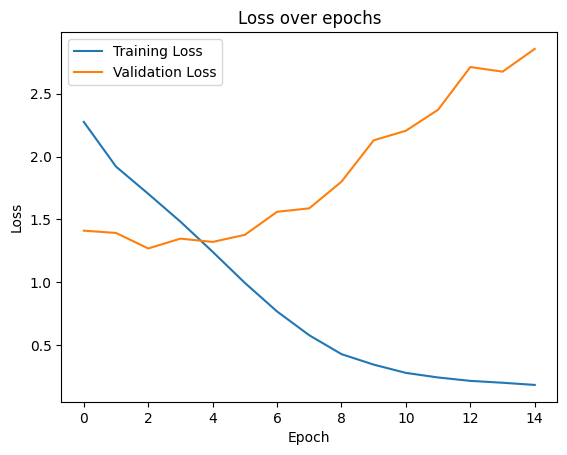

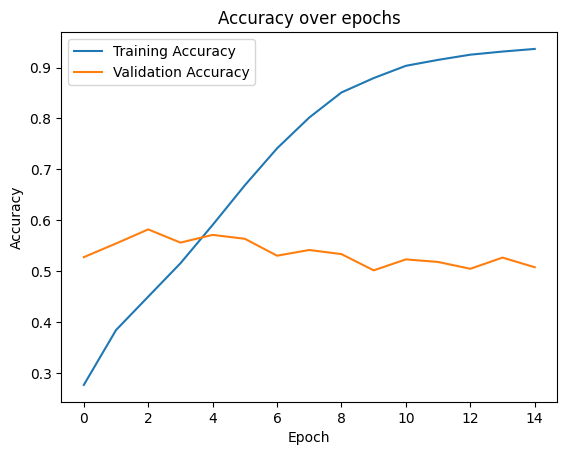

285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0944 - loss: 3.1563
Test Loss: 3.1563
Test Accuracy: 0.0944


In [ ]:
batch_size = 50
epochs = 15

history = model_over.fit(
    X_train, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val_cat),
    shuffle=True,
    verbose=1
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

score = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"Test Loss: {score[0]:.4f}")
print(f"Test Accuracy: {score[1]:.4f}")

This model overfits because it is too powerful for the size of the training dataset. 

It uses:

 - More convolution filters (60 and 120 vs. 60 and 30)
 - Much larger Dense layers (1000 and 500 units)
 - No dropout
 - Over 1.7 million trainable parameters

The model easily memorizes the training data, resulting in:

 - Training accuracy climbing above 95%
 - Validation accuracy stagnating or decreasing
 - Validation loss increasing while training loss decreases

These patterns indicate that the model is learning noise and overfitting rather than generalizing.